# Overall Planning for Mesa Debugging
- 1 [v] understanding the model, learning Mesa
- 2 [v] testing batch tun
- 3 [v] validating model on Centola paper
- 4 [v] categorizing variables, designing interface 
- 5 [v] testing server and experiment making batch run server
- 6 [] implimenting intervention design on the tooling

## 1 - Understandng Model and Learning Mesa 

In [20]:
## model
import math
import networkx as nx

from mesa import Agent, Model        ## This is the model - how agent interact 
from mesa.time import SimultaneousActivation      #This is the scheduler - how agents are activated
from mesa.datacollection import DataCollector     #This output a Pandas file
from mesa.space import NetworkGrid        #This means the model runs on  network (high dimentional space)


def number_state(model, state):
    return sum([a.state == state for a in model.grid.get_all_cell_contents()])


def number_infected(model):
    return number_state(model, "infected")


def number_susceptible(model):
    return number_state(model, "susceptible")


def infected_list(model):
    return model.datacollector.get_model_vars_dataframe()


class InfoSpread(Model):
    """A virus model with some number of agents"""

    def __init__(self, num_nodes=10, avg_node_degree=3, rewire_prob=.1, initial_outbreak_size=1, threshold = 2,):
        self.num_nodes = num_nodes
        self.G = nx.watts_strogatz_graph(n=self.num_nodes, k= avg_node_degree, p=rewire_prob)   #G generate graph structure
        self.grid = NetworkGrid(self.G) #grid is the Masa native defintion of space: a coorindate with specified topology on which agents sits and interact
        self.schedule = SimultaneousActivation(self)
        self.initial_outbreak_size = (
            initial_outbreak_size if initial_outbreak_size <= num_nodes else num_nodes
        )

        self.datacollector = DataCollector(
            {
                "Infected": number_infected,
                "Susceptible": number_susceptible,
            }
        )

        # Create agents
        for i, node in enumerate(self.G.nodes()):
            a = User(
                i,
                self,
                "susceptible",
                threshold
            )
            self.schedule.add(a)
            # Add the agent to the node
            self.grid.place_agent(a, node)

        # Infect some nodes
        infected_nodes = self.random.sample(self.G.nodes(), self.initial_outbreak_size)
        for a in self.grid.get_cell_list_contents(infected_nodes):
            a.state = "infected"
            neighbors_nodes = self.grid.get_neighbors(a.pos)
            for n in self.grid.get_cell_list_contents(neighbors_nodes):
                n.state = 'infected'

        self.running = True
        self.datacollector.collect(self)

    def proportion_infected(self):
        try:
            return number_state(self, "infected") / self.num_nodes
        except ZeroDivisionError:
            return math.inf

    def step(self):
        self.schedule.step()    #this model updates with symoutanous schedule, meaning, 
        # collect data
        self.datacollector.collect(self)

    def run_model(self, n):
        ''' could experiment terminating model here too'''
        for i in range(n):
            self.step()


class User(Agent):
    def __init__(self, unique_id, model, initial_state, threshold):
        super().__init__(unique_id, model)   #super(). is to inherent agent's property. The user class is a subset of the agent class with additional properties. All the papermeter here are inherited from orginial agent class, everything is new and specific to the user class
        self.state = initial_state
        self.threshold = threshold


    def get_infected_neighbor_count(self):
        '''Count how many of neighbors are infected'''
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        infected_neighbors = 0
        for n in self.model.grid.get_cell_list_contents(neighbors_nodes):
            if n.state == 'infected':   
                infected_neighbors += 1
        return infected_neighbors

    def step(self):
        '''Calculates what the state should be in the next step'''
        # Start as the current state and modify below
        self._next_state = self.state
        if self.state == 'susceptible':
            infected_neighbors = self.get_infected_neighbor_count()
            if infected_neighbors >= self.threshold:
                self._next_state = 'infected'

    def advance(self):
        self.state = self._next_state


## 2 - Testing Batch Run
### 2.1 Batch run improvements
These are additional functions to process th PANDAS document
- calculating the infection time (measured in steps it takes)
- calculating the infection percentage

In [4]:
# Find the time it needed to infect the whole/part network
def find_last_increase (a):
    i = 0
    for i in range(len(a)-2):
        if a[i] != a[i+1]:
            i += 1
        else:
            return(i+1)
    return(i+1)

def calculate_infection_time(df):
    time = []
    for i in range(df.shape[0]):
        inf_data = df['infection_list'][i]['Infected'].values.tolist()
        infection_time = find_last_increase(inf_data)
        time.append(infection_time)
    return(time)

In [5]:
#calculate percentage of infection
def find__final_infection_number (a):
    i = 0
    for i in range(len(a)-2):
        if a[i] != a[i+1]:
            i += 1
        else:
            return(a[i+1])
    return(a[i+1])

def calculate_total_infection(df):
    total_inf = []
    for i in range(df.shape[0]):
        inf_data = df['infection_list'][i]['Infected'].values.tolist()
        infection_num = find__final_infection_number(inf_data)
        total_inf.append(infection_num)
    return(total_inf)

### 2.2 Testing Batch Run with different average neighbors

In [3]:
model = InfoSpread (num_nodes=10, avg_node_degree=3, rewire_prob=.1, initial_outbreak_size=1, threshold = 2,)
#num_nodes=10, avg_node_degree=3, rewire_prob=.1, initial_outbreak_size=1, threshold = 2
for i in range(100):
    model.step()

<ipython-input-2-afaef7403751>:59: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected_nodes = self.random.sample(self.G.nodes(), self.initial_outbreak_size)


In [4]:
model = InfoSpread (num_nodes=10, avg_node_degree=3, rewire_prob=.1, initial_outbreak_size=1, threshold = 2,)
total_inf = [-1, 0] #buffer item
total_inf.append(number_infected(model))
while( total_inf[len(total_inf)-1] != total_inf[len(total_inf)-2] ):
    model.step()
    total_inf.append(number_infected(model))

<ipython-input-2-afaef7403751>:59: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected_nodes = self.random.sample(self.G.nodes(), self.initial_outbreak_size)


In [5]:
df = model.datacollector.get_model_vars_dataframe()
df

,Infected,Susceptible
0,3,7
1,3,7


In [63]:
#num_nodes=10, avg_node_degree=3, rewire_prob=.1, initial_outbreak_size=1, threshold = 2
rewire_list = []
for i in range(21):
    rewire_list.append(round((i*0.05),3))
#rewire_list = [0, 0.1, 0.2, 0.3]

fixed_params = {"rewire_prob":0.15,
                "num_nodes": 80,
               "initial_outbreak_size" : 1,
                "threshold" : 2
                }
variable_params = {"avg_node_degree": range(2,20)
                  
                  }  #  {"rewire_prob": range(0.05, 1.0, 0.05)}

batch_run = BatchRunner(InfoSpread,
                        variable_params,
                        fixed_params,
                        iterations=5,
                        max_steps=10,
                        model_reporters={"infection_list": infected_list})
batch_run.run_all()

0it [00:00, ?it/s]<ipython-input-2-afaef7403751>:59: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected_nodes = self.random.sample(self.G.nodes(), self.initial_outbreak_size)
90it [00:01, 59.13it/s]


In [42]:
run_data = batch_run.get_model_vars_dataframe()

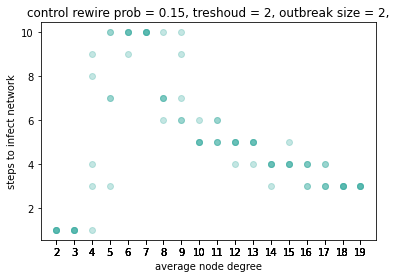

In [75]:
x = run_data['avg_node_degree'].values.tolist()
time = calculate_infection_time(run_data)
plt.plot(x,time,'o', color = '#3CAEA3', alpha = 0.3)
plt.xlabel("average node degree")
plt.ylabel("steps to infect network")
plt.title("control rewire prob = 0.15, treshoud = 2, outbreak size = 2,")
plt.xticks(x)
plt.show()

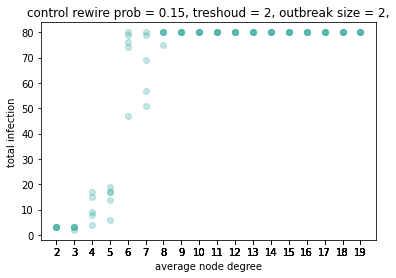

In [76]:
x = run_data['avg_node_degree'].values.tolist()
inf = calculate_total_infection(run_data)
plt.plot(x,inf,'o', color = '#3CAEA3', alpha = 0.3)
plt.xlabel("average node degree")
plt.ylabel("total infection")
plt.title("control rewire prob = 0.15, treshoud = 2, outbreak size = 2,")
plt.xticks(x)
plt.show()

### 2.3 Testing batch run with changing rewireing factor

In [79]:
#batch running test 2
from mesa.batchrunner import BatchRunner

#num_nodes=10, avg_node_degree=3, rewire_prob=.1, initial_outbreak_size=1, threshold = 2
rewire_list = []
for i in range(21):
    rewire_list.append(round((i*0.05),3))
#rewire_list = [0, 0.1, 0.2, 0.3]

fixed_params = {"num_nodes": 80,
               "avg_node_degree": 8,
               "initial_outbreak_size" : 1,
               "threshold" : 2}
variable_params = {"rewire_prob": rewire_list}  #  {"rewire_prob": drange(0.05, 1.0, 0.05)}

batch_run = BatchRunner(InfoSpread,
                        variable_params,
                        fixed_params,
                        iterations=5,
                        max_steps=10,
                        model_reporters={"infection_list": infected_list})
batch_run.run_all()

0it [00:00, ?it/s]<ipython-input-2-afaef7403751>:59: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected_nodes = self.random.sample(self.G.nodes(), self.initial_outbreak_size)
105it [00:01, 61.51it/s]


In [80]:
run_data = batch_run.get_model_vars_dataframe()
#run_data

In [82]:
import matplotlib.pyplot as plt
import numpy

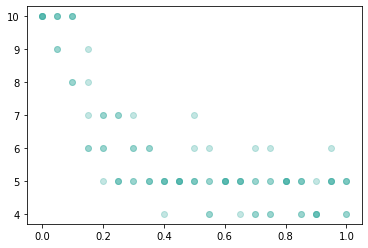

In [83]:

x = run_data['rewire_prob'].values.tolist()
time = calculate_infection_time(run_data)
plt.plot(x,time,'o', color = '#3CAEA3',alpha = 0.3)

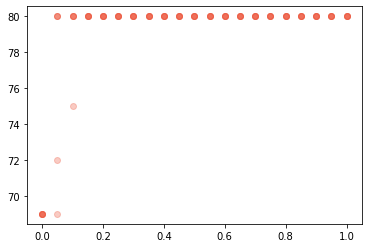

In [84]:
inf = calculate_total_infection(run_data)
plt.plot(x,inf,'o', color = '#ED553B', alpha = 0.3)

### 3 - Centola Replication

In [6]:
from mesa.batchrunner import BatchRunner

In [7]:
#num_nodes=40000, avg_node_degree=8, rewire_prob=a changing, initial_outbreak_size=1, threshold = 3
rewire_list = []
for i in range(201):
    rewire_list.append(round((i*0.005),4))

fixed_params = {"avg_node_degree":8,
                "num_nodes": 40,
               "initial_outbreak_size" : 1,
                "threshold" : 3
                }
variable_params = {
                      "rewire_prob": [0.000001, 0.00001,0.0001,0.001,0.01,0.1,1]
                  }  #  {"rewire_prob": range(0.05, 1.0, 0.05)}

batch_run = BatchRunner(InfoSpread,
                        variable_params,
                        fixed_params,
                        iterations=1,
                        max_steps=10,
                        model_reporters={"infection_list": infected_list})
batch_run.run_all()

0it [00:00, ?it/s]<ipython-input-3-afaef7403751>:59: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected_nodes = self.random.sample(self.G.nodes(), self.initial_outbreak_size)
7it [00:00, 56.09it/s]


In [9]:
run_data = batch_run.get_model_vars_dataframe()
run_data

,rewire_prob,Run,infection_list,avg_node_degree,num_nodes,initial_outbreak_size,threshold
0,0.000001,0,Infected Susceptible 0 9 ...,8,40,1,3
1,0.000010,1,Infected Susceptible 0 9 ...,8,40,1,3
2,0.000100,2,Infected Susceptible 0 9 ...,8,40,1,3
3,0.001000,3,Infected Susceptible 0 9 ...,8,40,1,3
4,0.010000,4,Infected Susceptible 0 9 ...,8,40,1,3
5,0.100000,5,Infected Susceptible 0 9 ...,8,40,1,3
6,1.000000,6,Infected Susceptible 0 12 ...,8,40,1,3


In [14]:
time = calculate_infection_time(run_data)

In [15]:
time

[9, 9, 9, 9, 9, 9, 4]

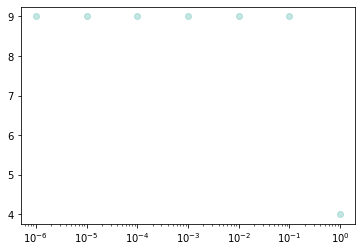

In [17]:
plt.plot(run_data.rewire_prob,time,'o', color = '#3CAEA3', alpha = 0.3)
plt.xscale('log')
plt.show()

In [10]:
import matplotlib.pyplot as plt

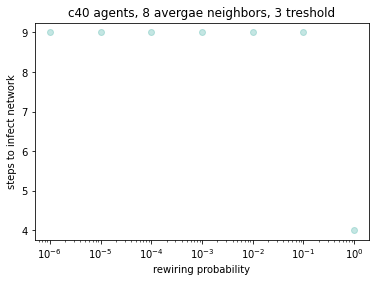

In [19]:
x = run_data.rewire_prob
time = calculate_infection_time(run_data)
plt.plot(x,time,'o', color = '#3CAEA3', alpha = 0.3)
plt.xlabel("rewiring probability")
plt.ylabel("steps to infect network")
plt.title("40 agents, 8 avergae neighbors, 3 treshold")
plt.xticks(x)
plt.xscale('log')
plt.show()

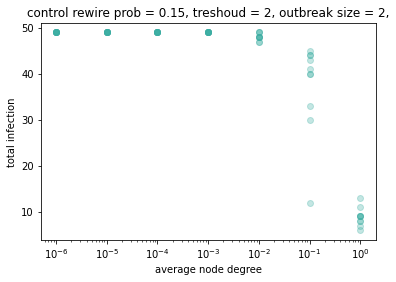

In [23]:
x = run_data['rewire_prob'].values.tolist()
inf = calculate_total_infection(run_data)
plt.plot(x,inf,'o', color = '#3CAEA3', alpha = 0.3)
plt.xlabel("average node degree")
plt.ylabel("total infection")
plt.title("control rewire prob = 0.15, treshoud = 2, outbreak size = 2,")
plt.xticks(x)
plt.xscale('log')
plt.show()

In [ ]:
#num_nodes=240000, avg_node_degree=48, rewire_prob=a changing, initial_outbreak_size=1, threshold = 19
rewire_list = []
for i in range(21):
    rewire_list.append(round((i*0.05),3))
#rewire_list = [0, 0.1, 0.2, 0.3]

fixed_params = {"rewire_prob":0.15,
                "num_nodes": 80,
               "initial_outbreak_size" : 1,
                "threshold" : 2
                }
variable_params = {"avg_node_degree": range(2,20)
                  
                  }  #  {"rewire_prob": range(0.05, 1.0, 0.05)}

batch_run = BatchRunner(InfoSpread,
                        variable_params,
                        fixed_params,
                        iterations=5,
                        max_steps=10,
                        model_reporters={"infection_list": infected_list})
batch_run.run_all()

## 4 & 5 Defining variables, design and experiment with server

### 5.1 Server

In [4]:
import math

from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import UserSettableParameter
from mesa.visualization.modules import ChartModule
from mesa.visualization.modules import NetworkModule
from mesa.visualization.modules import TextElement
# from .model import InfoSpread, number_infected


def network_portrayal(G):
    # The model ensures there is always 1 agent per node

    def node_color(agent):
        if agent.state == "infected":
            return "#FF0000"
        elif agent.state == 'susceptible':
            return "#008000"

    def edge_color(agent1, agent2):
        if "resistant" in (agent1.state, agent2.state):
            return "#000000"
        return "#e8e8e8"

    def edge_width(agent1, agent2):
        if "resistant" in (agent1.state, agent2.state):
            return 3
        return 2

    def get_agents(source, target):
        return G.nodes[source]["agent"][0], G.nodes[target]["agent"][0]

    portrayal = dict()
    portrayal["nodes"] = [
        {
            "size": 6,
            "color": node_color(agents[0]),
            "tooltip": "id: {}<br>state: {}".format(
                agents[0].unique_id, agents[0].state
            ),
        }
        for (_, agents) in G.nodes.data("agent")
    ]

    portrayal["edges"] = [
        {
            "source": source,
            "target": target,
            "color": edge_color(*get_agents(source, target)),
            "width": edge_width(*get_agents(source, target)),
        }
        for (source, target) in G.edges
    ]

    return portrayal


network = NetworkModule(network_portrayal, 500, 500, library="d3")
chart = ChartModule(
    [
        {"Label": "Infected", "Color": "#FF0000"},
        {"Label": "Susceptible", "Color": "#008000"},
        {"Label": "Resistant", "Color": "#808080"},
    ]
)


class MyTextElement(TextElement):
    def render(self, model):
        ratio = model.proportion_infected()
        ratio_text = "&infin;" if ratio is math.inf else "{0:.2f}".format(ratio)
        infected_text = number_infected(model)

        return "Proportion Infected: {}<br>Infected: {}".format(
            ratio_text, infected_text
        )


model_params = {
    "num_nodes": UserSettableParameter(
        "slider",
        "Number of agents",
        10,
        10,
        100,
        1,
        description="Choose how many agents to include in the model",
    ),
    
    "avg_node_degree": UserSettableParameter(
        "slider", "Avg Node Degree", 4, 2, 8, 2, description="Avg Node Degree"
    ),
    
    "rewire_prob": UserSettableParameter(
        "slider",
        "Rewire Probability",
        .1,
        0,
        1,
        .05,
        description = "Rewire probability"),
    
    "initial_outbreak_size": UserSettableParameter(
        "slider",
        "Initial Outbreak Size",
        1,
        1,
        5,
        1,
        description="Initial Outbreak Size",
    ),
    "threshold": UserSettableParameter(
        "slider",
        "Neighbor Threshold",
        2,
        1,
        5,
        1,
        description="Neighbor Threshold",
    )
}

server = ModularServer(
    InfoSpread, [network, MyTextElement(), chart], "Complex Contagion Model", model_params
)
server.port = 8521



<ipython-input-1-439a7ac5e84d>:55: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected_nodes = self.random.sample(self.G.nodes(), self.initial_outbreak_size)


In [38]:
#testing visualizing charts in a server
from mesa.visualization.modules import ChartModule
from mesa.visualization.ModularVisualization import ModularServer
from model import InfoSpread, number_infected
from mesa.visualization.modules import TextElement




In [39]:
class MyTextElement(TextElement):
    def render(self, model):
        ratio = model.proportion_infected()
        ratio_text = "&infin;" if ratio is math.inf else "{0:.2f}".format(ratio)
        infected_text = number_infected(model)

        return "Proportion Infected: {}<br>Infected: {}".format(
            ratio_text, infected_text
        )

In [43]:
chart = ChartModule([
        {"Label": "Infected", "Color": "#FF0000"},
        {"Label": "Susceptible", "Color": "#008000"},
        {"Label": "Resistant", "Color": "#808080"},
    ])

server = ModularServer(InfoSpread,
                       [ MyTextElement(), chart],
                       "Complex Comtagion Batch Run")

In [ ]:
server.port = 8521 # The default
server.launch()

## 6 - Impliment one intervention


## Legacy code

In [ ]:
#define a better range function
def drange(x, y, jump):
  while x < y:
    yield round(float(x),2)
    x += jump